In [1]:
# General
import pandas as pd 
import numpy as np
from ast import literal_eval
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import pickle
import compress_pickle
import joblib
from time import time
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams,everygrams
import json

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

# Word2Vec
from gensim.models import Word2Vec
import multiprocessing
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# Load Data

The 'parsed_trainfile.csv' can be found in the Processed JSONs folder in th shared drive - https://drive.google.com/drive/folders/1eDEeQldaYod7bWUD1Sr9Q3KaP_MzNK9X?usp=sharing

In [2]:
# Modify this path to point to where the data is saved
DATAPATH = '../../data/'
filepath = 'newcleaned_trainfile.csv'
df = pd.read_csv(DATAPATH+filepath)
df.ingredients = [literal_eval(x) for x in df.ingredients]
df = df.drop(columns = ['Unnamed: 0'])
df.head()

,ingredients,url,partition,title,id,instructions
0,"[penne, beechers flagship cheese sauce, chedda...",http://www.epicurious.com/recipes/food/views/-...,train,worlds mac cheese,000018c8a5,[{'text': 'Preheat the oven to 350 F. Butter o...
1,"[elbow macaroni, american cheese, celery, gree...",http://cookeatshare.com/recipes/dilly-macaroni...,train,dilly macaroni salad,000033e39b,[{'text': 'Cook macaroni according to package ...
2,"[tomato, salt, red onion into dice, green bell...",http://www.foodnetwork.com/recipes/gazpacho1.html,train,gazpacho,000035f7ed,[{'text': 'Add the tomatoes to a food processo...
3,"[watermelon gelatin, water, cool whip thawed, ...",http://www.food.com/recipe/cool-n-easy-creamy-...,train,cool easy creamy watermelon pie,00004320bb,"[{'text': 'Dissolve Jello in boiling water.'},..."
4,"[shredded coconut, lean ground beef, -2 fresh ...",http://www.food.com/recipe/easy-tropical-beef-...,train,easy tropical beef skillet,0000631d90,"[{'text': 'In a large skillet, toast the cocon..."


In [16]:
# Setup vectorizer inputs
string_ingr = [] # input strings (documents) for vectorizer
vocab = set() # vocabulary for vectorizer
for ingr_list in df.ingredients:
    string_ingr.append(' '.join(ingr_list))
    vocab.update(ingr_list)   
vocab = {term: i for i,term in enumerate(vocab)}

# Load Models

In [4]:
# Modify this path to point to where the models are saved
RELMODELPATH = '../streamlitapp/models/'

## Vectorizer

In [5]:
# load fitted vectorizer (~34 sec)
with open(RELMODELPATH+'vectorizer.pkl','rb') as f:
    vectorizer = pickle.load(f)
# Setup output vectors for later
vect_ingr = vectorizer.transform(string_ingr)
vect_features = vectorizer.get_feature_names_out()
titles = df.title

# Uncomment below to refit vectorizer
# # Create and fit vectorizer
# vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=10, max_df=1.0, stop_words="english", max_features=2000, vocabulary=vocab)  
# vect_ingr = vectorizer.fit_transform(string_ingr)

# # Setup output vectors for later
# titles = df.title
# vect_features = vectorizer.get_feature_names_out()

# Save fitted vectorizer
# with open(RELMODELPATH+'nmf_models/vectorizer.pkl','wb') as f:
#     pickle.dump(vectorizer,f)

c:\Users\jrmcn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## LDA Models

In [12]:
# Setup LDA
ns = [20]
# If already trained, load models
# ldas = []
# for n in ns:
#     filename = RELMODELPATH+'lda_model_n{}.gz'.format(n)
#     with open(filename,'rb') as f:
#         ldas.append(compress_pickle.load(f))

# Else, uncomment to train (~15 min per model)
ldas = []
for n in tqdm(ns):
    lda = LatentDirichletAllocation(n_components = n, random_state=0,n_jobs=6,verbose=3)
    lda.fit(vect_ingr) # fit to the vectorized ingredients list
    ldas.append(lda)

# Save Models
for i,lda in enumerate(ldas):
    filename = 'lda_model_n{}.pkl'.format(ns[i])
    with open(RELMODELPATH+filename,'wb') as f:
            compress_pickle.dump(lda, f)


  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.8min finished


iteration: 1 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.5min finished


iteration: 2 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  1.1min finished


iteration: 3 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   56.0s remaining:   56.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   57.0s finished


iteration: 4 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   49.6s remaining:   49.6s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   50.6s finished


iteration: 5 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   49.9s remaining:   49.9s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   51.0s finished


iteration: 6 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   46.6s remaining:   46.6s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   47.7s finished


iteration: 7 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   47.6s remaining:   47.6s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   48.5s finished


iteration: 8 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   46.0s remaining:   46.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   47.0s finished


iteration: 9 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   42.6s remaining:   42.6s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   43.6s finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   30.0s remaining:   30.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   30.3s finished
100%|██████████| 1/1 [11:32<00:00, 692.84s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'lda_models/lda_model_n40.pkl'

## W2V model

In [ ]:
# load w2v model if already trained
modelpath = 'C:/Users/jrmcn/MADS/MADS_Capstone/m2/streamlit_app/models/'
with open(relmodelpath+'word2vec_model.pkl','rb') as f:
        w2v_model = pickle.load(f)

# # uncomment to train new w2v model
# cores = multiprocessing.cpu_count()
# w2v_model = Word2Vec(min_count=20,
#                      window=2,
#                      vector_size=2000,
#                      sample=6e-5, 
#                      alpha=0.03, 
#                      min_alpha=0.0007, 
#                      negative=20,
#                      workers=cores-1)

# word_freq = Counter()
# for word_list in df.ingredients: 
#         word_freq.update(word_list)
# print(word_freq.most_common(5))

# # Train w2v model (takes ~12 min)
# w2v_model.build_vocab_from_freq(word_freq)
# t = time()
# w2v_model.train(df.ingredients, total_examples=df.ingredients.shape[0], epochs=30, report_delay=1)
# print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# with open('../models/lda_models/new_word2vec_model.pkl','wb') as f:
#         pickle.dump(w2v_model, f)

# Helper Functions

## Display Topics

In [7]:
def display_topics(model, feature_names, no_top_words, idx=None):
    """
    if index is specified, the function will print the topic words for that index
    and return the terms

    if no index is specified it will print all of the words for each topic with no return
    """

    if idx != None:
       topic = model.components_[idx]
       term_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
       print("topic %d:" % (idx), term_list)
       return term_list
    else:    
        for topic_idx, topic in enumerate(model.components_):
            term_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
            print("topic %d:" % (topic_idx), term_list)

num_top_words = 8
display_topics(ldas[0], vect_features, num_top_words)

topic 0: ['water', 'oil', 'salt', 'flour', 'vegetable', 'vegetable oil', 'dry', 'sugar']
topic 1: ['cubes', 'chicken', 'inch cubes', 'water', 'curry', 'bouillon', 'powder', 'curry powder']
topic 2: ['cheese', 'pepper', 'salt', 'egg', 'onion', 'cheddar', 'cheddar cheese', 'salt pepper']
topic 3: ['pepper', 'red', 'garlic', 'salt', 'fresh', 'oil', 'ground', 'cumin']
topic 4: ['ground', 'cinnamon', 'sugar', 'ground cinnamon', 'brown', 'nutmeg', 'brown sugar', 'apples']
topic 5: ['cream', 'pepper', 'sour', 'sour cream', 'salt', 'sauce', 'mayonnaise', 'onion']
topic 6: ['cheese', 'parmesan', 'parmesan cheese', 'fresh', 'basil', 'olive', 'olive oil', 'oil']
topic 7: ['potatoes', 'inch', 'pieces', 'inch pieces', 'sweet', 'carrots', 'boiled', 'eggs']
topic 8: ['oil', 'olive', 'olive oil', 'pepper', 'salt', 'vinegar', 'red', 'salt pepper']
topic 9: ['powder', 'pepper', 'sauce', 'salt', 'garlic', 'onion', 'sugar', 'mustard']
topic 10: ['egg', 'unsalted', 'butter', 'unsalted butter', 'sugar', 'sa

## Summarize Topics

In [8]:
def summarize_topic(top_recipes_per_topic,top_scores_per_topic,n_topics, num_top_recipes=20):
    # summarize topics from most common tokens in recipe titles | also return top recipe titles
    # num_top_recipes = 20 # number of recipes to be included in token counting
    num_top_words_in_topic = 8 # number of tokens to display from each topic
    num_summary_tokens = 6 # number of tokens to summarize recipe titles
    num_summary_recipes = 5 # number of recipes to display
    num_top_words = 8 # number of words to display
    
    most_commons = []
    for topic_index in range(0, n_topics):
        top_indices = top_recipes_per_topic[0:num_top_recipes, topic_index]
        top_titles = titles[top_indices]
        top_title_scores = top_scores_per_topic[0:num_top_recipes, topic_index]
        top_title_scores = [round(score,3) for score in top_title_scores]

        tokens = Counter()
        for title in top_titles.values:
            title_toks = title.split()
            ngrams = list(everygrams(title_toks, max_len = 2))
            n_gram_tokens = []
            for gram in ngrams:
                combined = []
                for i in range(len(gram)):
                    combined.append(gram[i])
                combined = ' '.join(combined)
                n_gram_tokens.append(combined)
            tokens.update(n_gram_tokens)

        most_common = tokens.most_common(num_summary_tokens)
        most_commons.append(most_common)
        mc_sum = sum([x[1] for x in most_common])
        tok_return = [(x[0], str(round(100*x[1]/mc_sum,1))+'%') for x in most_common]
        
        display_topics(lda, vect_features, num_top_words, topic_index)
        print("Most common tokens in recipes for topic", topic_index, "are:\n", tok_return)

        title_output = list(zip(top_titles[:num_summary_recipes].values, top_title_scores))
        print("Highest topic", topic_index, "weighted recipes are:\n", title_output)
        print('\n') 
    return most_commons

## Make Word Cloud

In [9]:
def make_wordcloud(most_common):
    toks = {x[0]:x[1] for x in most_common}
    wc = WordCloud(prefer_horizontal=1, background_color='white')
    wc.generate_from_frequencies(toks)
    # ax.imshow(wc, interpolation='bilinear')
    # ax.axis('off')
    return wc

# LDA

In [13]:
# transform vectorized ingredients to LDA space (~3 min)
lda_outputs = []
top_recipes = []
top_scores = []
for lda in ldas:
    lda_output = lda.transform(vect_ingr)
    top_recipes_per_topic = np.argsort(lda_output, axis = 0)[::-1] # sort recipes for each topic
    top_scores_per_topic = np.sort(lda_output, axis = 0)[::-1] # sort recipes for each topic

    lda_outputs.append(lda_output)
    top_recipes.append(top_recipes_per_topic)
    top_scores.append(top_scores_per_topic)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   28.8s remaining:   28.8s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   29.0s finished


### Log-Like and Perplexity

In [ ]:
# Compute log-likelihood and perplexity (~11 min)
log_like = []
perplex = []
for lda in ldas:
    log_like.append(lda.score(vect_ingr))
    perplex.append(lda.perplexity(vect_ingr))

In [ ]:
# create log-like and perplexity graph
xlab = [str(n) for n in ns]

fig, ax1 = plt.subplots(figsize=(5,5))
ax1.plot(xlab,log_like,c='red',label='log-like')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Log-Likelihood')
ax1.set_title('LDA Comparison of n Topics', weight='bold')

ax2 = ax1.twinx()
ax2.plot(xlab,perplex,c='blue',label='perplexity')
ax2.set_ylabel('Perplexity')

fig.legend(bbox_to_anchor=(.9,.55))


## LDA Topic Coherence Functions

In [ ]:
# check similarity of topics to themselves and take average
def lda_topic_coherence(model,n_topics,n_top_words=50):
    total_avg = []
    for idx in range(n_topics):
        topic = model.components_[idx]
        term_list = [vect_features[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        scores = []
        for term1 in term_list:
            for term2 in term_list:
                if term1 != term2:
                    try:
                        scores.append(w2v_model.wv.similarity(w1=term1, w2=term2))
                    except:
                        pass
        total_avg.append(np.mean(scores))
    return np.mean(total_avg)

lda_avg_coherence = []
for i,lda in enumerate(ldas):
    lda_avg_coherence.append(lda_topic_coherence(lda,ns[i]))

In [ ]:
def plot_coherence(avg_coherence, ax, model_type):
    xlabels = [str(x) for x in ns]
    ax.plot(xlabels,avg_coherence, c='blue',label = 'Coherence')
    ax.scatter(xlabels,avg_coherence)
    ax.set_xlabel('Number of Topics')
    ax.set_ylabel('Average Topic Coherence')
    ax.set_title('{} Topic Coherence vs Number of Topics'.format(model_type), weight='bold')
    ax.axhline(y=np.mean(avg_coherence), c='red', label='Mean')
    # plt.legend()|

## LDA Word Cloud

topic 0: ['oil', 'water', 'vegetable', 'salt', 'vegetable oil', 'flour', 'dry', 'yeast']
Most common tokens in recipes for topic 0 are:
 [('bread', '40.7%'), ('pizza', '16.7%'), ('dough', '14.8%'), ('pizza dough', '13.0%'), ('basic', '7.4%'), ('bread machine', '7.4%')]
Highest topic 0 weighted recipes are:
 [('chicago style deep dish pizza dough', 0.974), ('basic focaccia dough', 0.973), ('bread machine cookbook semolina bread', 0.972), ('brooklyn bialy', 0.97), ('country bread', 0.97)]


topic 1: ['ground', 'cubes', 'inch cubes', 'cumin', 'chicken', 'ground cumin', 'inch', 'bouillon']
Most common tokens in recipes for topic 1 are:
 [('spice', '22.6%'), ('chicken', '22.6%'), ('spice mix', '16.1%'), ('mix', '16.1%'), ('lamb', '12.9%'), ('hawaij', '9.7%')]
Highest topic 1 weighted recipes are:
 [('tandoori spice mix', 0.959), ('hawaij purpose seasoning', 0.951), ('hawaiij spice mix', 0.946), ('quick hawaij', 0.943), ('coriander spice mix', 0.943)]


topic 2: ['cheese', 'parmesan', 'parme

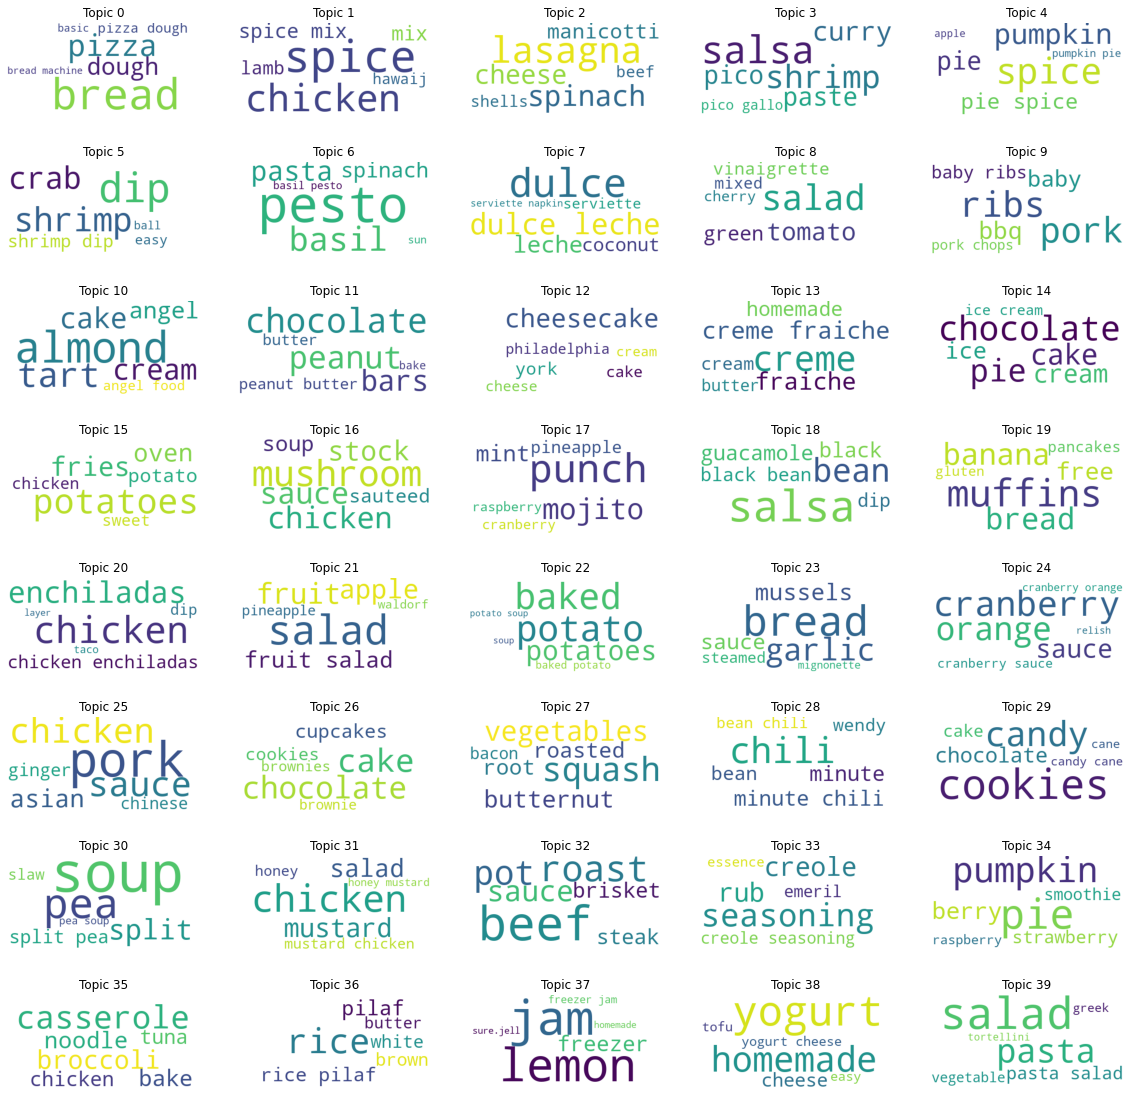

In [15]:
most_commons = summarize_topic(top_recipes[0],top_scores[0],40,40);

rows = int(len(most_commons)/5)
cols = int(len(most_commons)/rows)
figy = rows*5/2
fig = plt.figure(figsize=(20,figy))
for i, most_common in enumerate(most_commons):
    ax = fig.add_subplot(rows,cols,i+1)
    wc = make_wordcloud(most_common)
    ax.imshow(wc)
    ax.axis('off')
    ax.set_title('Topic '+str(i))
# plt.savefig('word_cloud')   

In [ ]:
# Individual LDA Plot 
xlabels = [str(x) for x in ns]

fig, axs = plt.subplots(figsize=(5,5))

axs.plot(xlabels,lda_avg_coherence, c='red',label='LDA')
axs.scatter(xlabels,lda_avg_coherence, c = 'red')
axs.set_xlabel('Number of Topics')
axs.set_ylabel('Average Topic Coherence')
axs.set_title('LDA Topic Coherence', weight='bold')
axs.set_ylim([.1, .2])